In [1]:
import pinocchio as pin
import math
import time
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.utils import *
import pinocchio as pio
import eigenpy
from scipy.optimize import fmin_bfgs
import numpy as np

import casadi as ca

from pinocchio import casadi as cpin

# from pinocchio.visualize import GepettoVisualizer

import matplotlib.pyplot as plt

## **Chargement du URDF avec `pinocchio`**

Dans un premier temps, j'ai utilisé `gepetto-gui` pour l'instant, car c'est celui que j'ai le mieux réussi à faire fonctionner pour l'instant. \
Cela nécessite donc de lancer `gepetto-gui` dans un terminal, avec un environnement conda qui embarque ce package, sur mon poste cet environnement s'appelle `env_casadi`.

In [2]:
exampleRobotDataPath = '/home/n7student/Documents/Boulot/CNRS@CREATE/Codes/OC & IRL/Starting/3 - URDF et pinocchio/assets/'
urdf = exampleRobotDataPath + 'mon_robot.urdf'
robot = RobotWrapper.BuildFromURDF( urdf, [ exampleRobotDataPath, ] )
# robot.setVisualizer(GepettoVisualizer()) # AJOUT
robot.initViewer(loadModel=True)
NQ = robot.model.nq
NV = robot.model.nv

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [3]:
print("valeur de NQ :", NQ, "\nvaleur de NV :", NV)

valeur de NQ : 2 
valeur de NV : 2


In [4]:
robot.model

Nb joints = 3 (nq=2,nv=2)
  Joint 0 universe: parent=0
  Joint 1 joint1: parent=0
  Joint 2 joint2: parent=1

In [5]:
IDX_EE = robot.model.getFrameId('ee_link')
robot.model.frames[IDX_EE]

Frame name: ee_link paired to (parent joint/ parent frame)(2/7)
with relative placement wrt parent joint:
  R =
1 0 0
0 1 0
0 0 1
  p = 1 0 0
containing inertia:
  m = 0
  c = 0 0 0
  I = 
0 0 0
0 0 0
0 0 0

In [6]:
IDX_EE

8

In [7]:
IDX_BASE = robot.model.getFrameId('base')
robot.model.frames[IDX_BASE]

Frame name: base paired to (parent joint/ parent frame)(0/1)
with relative placement wrt parent joint:
  R =
1 0 0
0 1 0
0 0 1
  p = 0 0 0
containing inertia:
  m = 0
  c = 0 0 0
  I = 
0 0 0
0 0 0
0 0 0

### **Affichage du robot en position neutre**

In [8]:
q = pin.neutral(robot.model)  # configuration neutre
robot.display(q)

In [9]:
q

array([0., 0.])

### **Affichage du robot dans une suite de configurations de joints**

In [10]:
n_echantillons = 100

# q1_test = np.linspace(0, math.pi/2, n_echantillons)
q1_test = np.random.normal(loc=math.pi/4, scale=math.pi/16, size=n_echantillons)
# q2_test = np.linspace(math.pi/2, -math.pi/2, n_echantillons)
q2_test = np.random.normal(loc=0, scale=math.pi/8, size=n_echantillons)

q1_test = np.sort(q1_test)
q2_test = np.sort(q2_test)

In [11]:
for i in range(n_echantillons):
    q_test = np.array([q1_test[i],q2_test[i]])
    robot.display(q_test)
    time.sleep(0.1)

In [30]:
pin.computeFrameJacobian(robot.model,robot.data,np.array([q1_test[i],q2_test[i]]),IDX_EE)[:2,:2].shape

(2, 2)

In [67]:
pin.ReferenceFrame.LOCAL_WORLD_ALIGNED

pinocchio.pinocchio_pywrap_default.ReferenceFrame.LOCAL_WORLD_ALIGNED

In [11]:
# Jee_list = np.zeros((2,2,n_echantillons))
Jee_list = np.zeros((6,2,n_echantillons))
evol_x_random_pin = []
evol_y_random_pin = []
evol_z_random_pin = []

for i in range(n_echantillons):
    pin.framesForwardKinematics(robot.model, robot.data, np.array([q1_test[i],q2_test[i]]))
    pin.updateFramePlacements(robot.model,robot.data)
    # print("Tool placement:",robot.data.oMf[IDX_EE])
    oMtool = robot.data.oMf[IDX_EE]
    oRtool = oMtool.rotation
    # Jee = oRtool[:2,:2] @ (pin.computeFrameJacobian(robot.model,robot.data,np.array([q1_test[i],q2_test[i]]),IDX_EE)[:2,:2])
    Jee = pin.computeFrameJacobian(robot.model, robot.data, np.array([q1_test[i],q2_test[i]]), IDX_EE, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
    # print(Jee[0:2])
    Jee_list[:,:,i] = Jee
    # print(log_det_JJt_fun([q1_test[i],q2_test[i]]))
    evol_x_random_pin.append(robot.data.oMf[-1].translation[0])
    evol_y_random_pin.append(robot.data.oMf[-1].translation[1])
    evol_z_random_pin.append(robot.data.oMf[-1].translation[2])

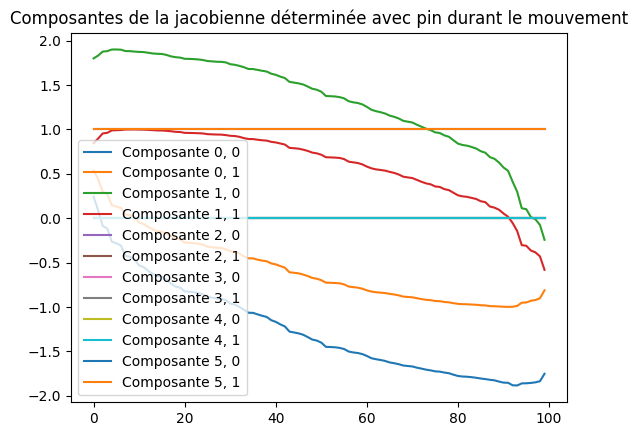

In [12]:
nb_directions, nb_DL, _ = Jee_list.shape
for ind_vit in range(nb_directions):
    for ind_DL in range(nb_DL):
        plt.plot(Jee_list[ind_vit,ind_DL,:], label=f"Composante {ind_vit}, {ind_DL}")
plt.title("Composantes de la jacobienne déterminée avec pin durant le mouvement")
plt.legend()
plt.show()

## **Réimplémentation du problème de contrôle optimal direct**

**NOTE :** dans cette partie, je pense qu'il faudrait plus utiliser `cpin` mais je ne l'ai pour l'instant pas fait (j'imagine que les angles sont obtenus avec des `model.getq()`ou quelque chose comme ça, qu'on a sûrement aussi un moyen de calculer les jacobien en faisant des `cpin.getJacobian(model)`, mais ce que j'ai tenté pour l'instant avec `cpin` n'était pas fonctionnel)

In [9]:
opti = ca.Opti()

# cadre du problème
# temporel
t_0 = 0
t_f = 1
N = 100  # nombre de points de discrétisation
dt = (t_f - t_0) / N

# longueurs
L_1 = 1
L_2 = 1
N_angles = 2

# variables à optimiser
q = opti.variable(N_angles, N)
dq = opti.variable(N_angles, N)

# déclaration de la matrice de poids
# NOTE : j'avais mis des np.ones au début, mais cela ne marchait pas, il faut essayer de rester avec des objets casadi
w_1 = ca.DM.ones((N_angles, N))
w_2 = ca.DM.zeros(N)
w_3 = ca.DM.zeros(N)
w_4 = ca.DM.ones(N)


# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = dq**2
J_1 = w_1[0,:] @ Phi_1[0,:].T + w_1[1,:] @ Phi_1[1,:].T

# variables symboliques indépendantes pour un pas de temps
# q_sym = ca.MX.sym("q", 2)
# q_sym = ca.SX.sym("q", 2)
q1_sym = ca.SX.sym("q1")
q2_sym = ca.SX.sym("q2")
# dq_sym = ca.MX.sym("dq", 2)
# dq_sym = ca.SX.sym("dq", 2)
dq1_sym = ca.SX.sym("dq1")
dq2_sym = ca.SX.sym("dq2")


# NOTE : les implémentations de Px et gradient sont inexactes, je vais les réimplémenter

"""
# Px et gradient
Px = L_1*ca.cos(q_sym[0]) + L_2*ca.cos(q_sym[0] + q_sym[1])
grad_Px = ca.gradient(Px, q_sym)
dPx_sq_fun = ca.Function("dPx_sq", [q_sym], [ca.dot(grad_Px, grad_Px)])

# Py et gradient
Py = L_1*ca.sin(q_sym[0]) + L_2*ca.sin(q_sym[0] + q_sym[1])
grad_Py = ca.gradient(Py, q_sym)
dPy_sq_fun = ca.Function("dPy_sq", [q_sym], [ca.dot(grad_Py, grad_Py)])
"""


# Réimplémentation de Px et Py
# Px = L_1*ca.cos(q_sym[0]) + L_2*ca.cos(q_sym[0] + q_sym[1])
Px = L_1*ca.cos(q1_sym) + L_2*ca.cos(q1_sym + q2_sym)
Px_fun = ca.Function("Px", [q1_sym, q2_sym], [Px])
# Py = L_1*ca.sin(q_sym[0]) + L_2*ca.sin(q_sym[0] + q_sym[1])
Py = L_1*ca.sin(q1_sym) + L_2*ca.sin(q1_sym + q2_sym)
Py_fun = ca.Function("Py", [q1_sym, q2_sym], [Py])
# grad_Px = ca.gradient(Px, q_sym)
grad_Px = ca.gradient(Px, ca.vertcat(q1_sym, q2_sym))
# grad_Py = ca.gradient(Py, q_sym)
grad_Py = ca.gradient(Py, ca.vertcat(q1_sym, q2_sym))
# dPx_fun = ca.Function("dPx", [q_sym, dq_sym] , [grad_Px.T @ dq_sym])
dPx_fun = ca.Function("dPx", [ca.vertcat(q1_sym, q2_sym), ca.vertcat(dq1_sym, dq2_sym)] , [grad_Px.T @ ca.vertcat(dq1_sym, dq2_sym)])
# dPy_fun = ca.Function("dPy", [q_sym, dq_sym] , [grad_Py.T @ dq_sym])
dPy_fun = ca.Function("dPy", [ca.vertcat(q1_sym, q2_sym), ca.vertcat(dq1_sym, dq2_sym)] , [grad_Py.T @ ca.vertcat(dq1_sym, dq2_sym)])



# q_sym2 = ca.SX.sym("q2", 2)

# f et Jacobien
# f = ca.vertcat(L_1*ca.cos(q_sym[0]) + L_2*ca.cos(q_sym[0] + q_sym[1]),
#             L_1*ca.sin(q_sym[0]) + L_2*ca.sin(q_sym[0] + q_sym[1]))
f = ca.vertcat(L_1*ca.cos(q1_sym) + L_2*ca.cos(q1_sym + q2_sym),
            L_1*ca.sin(q1_sym) + L_2*ca.sin(q1_sym + q2_sym),
            0)
# f = ca.Function("f", [q_sym2], [ca.vertcat(L_1*ca.cos(q_sym2[0]) + L_2*ca.cos(q_sym2[0] + q_sym2[1]),
#             L_1*ca.sin(q_sym2[0]) + L_2*ca.sin(q_sym2[0] + q_sym2[1]))])
# J = ca.jacobian(f, q_sym)
J = ca.jacobian(f, ca.vertcat(q1_sym, q2_sym))
J_func = ca.Function("J_func", [q1_sym, q2_sym], [J])
JTJ = J.T @ J
# JTJ = ca.Function("JJt", [q_sym2], [J.T @ J])
eps = 1e-6
# NOTE : j'avais tenté une autre approche pour le coût suivant, mais on m'a dit de l'abandonner
# log_det_JJt_fun = Function("log_det_JJt", [q_sym2], [-log(fabs(det(JJt) - 1))])
# log_det_JJt_fun = ca.Function("log_det_JJt", [q_sym2], [-ca.log(ca.det(JTJ) + eps)])
# log_det_JJt_fun = ca.Function("log_det_JJt", [q_sym], [-ca.log(ca.det(JTJ) + eps)])
log_det_JJt_fun = ca.Function("log_det_JJt", [ca.vertcat(q1_sym, q2_sym)], [-ca.log(ca.det(JTJ) + eps)])
JJt_fun = ca.Function("JJt", [ca.vertcat(q1_sym, q2_sym)], [JTJ])

J_2 = 0
J_3 = 0
J_4 = 0
for t in range(N):
    q_t = ca.vertcat(q[0, t], q[1, t])
    dq_t = ca.vertcat(dq[0, t], dq[1, t])
    # J_2 += w_2[t] * dPx_sq_fun(q_t)
    J_2 += w_2[t] * ca.sqrt(dPx_fun(q_t, dq_t)**2)
    # J_3 += w_3[t] * dPy_sq_fun(q_t)
    J_3 += w_2[t] * ca.sqrt(dPy_fun(q_t, dq_t)**2)
    J_4 += w_4[t] * log_det_JJt_fun(q_t)

# fonction que l'on cherche à minimiser
opti.minimize(J_1 + J_2 + J_3 + J_4)

# contraintes d’intégration
for t in range(N-1):
    opti.subject_to(q[:, t+1] == q[:, t] + dt * dq[:, t])
opti.subject_to(q[:, 0] == [0, ca.pi/4])
opti.subject_to(L_1*ca.cos(q[0, -1]) + L_2*ca.cos(q[0, -1] + q[1, -1]) == -0.75)

# conditions supplémentaires sur les angles, non demandé dans l'énoncé
# opti.subject_to(opti.bounded(-pi/2, q, pi/2))

opti.solver("ipopt")
sol = opti.solve()

q1 = sol.value(q[0,:])
q2 = sol.value(q[1,:])

dq1 = sol.value(dq[0,:])
dq2 = sol.value(dq[1,:])

print("q1 =", q1)
print("q2 =", q2)
print("dq1 =", dq1)
print("dq2 =", dq2)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      598
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      500

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      201
Total number of inequality c

In [12]:
evol_x_random_casadi = np.zeros(n_echantillons)
evol_y_random_casadi = np.zeros(n_echantillons)

for i in range(n_echantillons):
    # print(Px_fun(np.array([q1_test[i],q2_test[i]])))
    evol_x_random_casadi[i] = Px_fun(q1_test[i],q2_test[i])
    evol_y_random_casadi[i] = Py_fun(q1_test[i],q2_test[i])

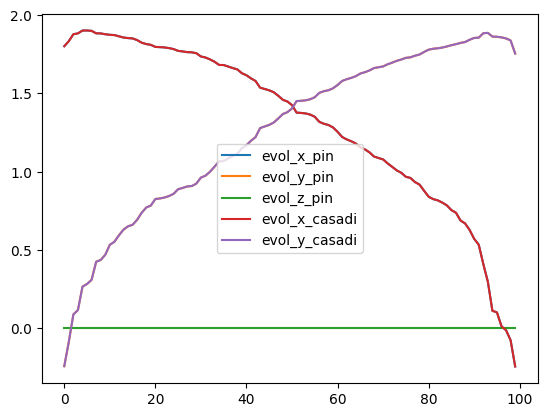

In [15]:
plt.plot(evol_x_random_pin, label = "evol_x_pin")
plt.plot(evol_y_random_pin, label = "evol_y_pin")
plt.plot(evol_z_random_pin, label = "evol_z_pin")
plt.plot(evol_x_random_casadi, label = "evol_x_casadi")
plt.plot(evol_y_random_casadi, label = "evol_y_casadi")
plt.legend()
plt.show()

In [10]:
robot.display(np.array([q1[0], q2[0]]))

time.sleep(2)
for i in range(N):
    robot.display(np.array([q1[i],q2[i]]))
    time.sleep(0.1)

##### **Affichage des jacobiennes obtenues automatiquement avec `pin`**

In [16]:
# Jee_list = np.zeros((2,2,N))
Jee_casadi_list = np.zeros((3,2,N))

for i in range(N):
    Jee_casadi_list[:,:,i] = J_func(q1_test[i],q2_test[i])

Text(0.5, 1.0, 'Composantes de la jacobienne déterminée avec pin durant le mouvement')

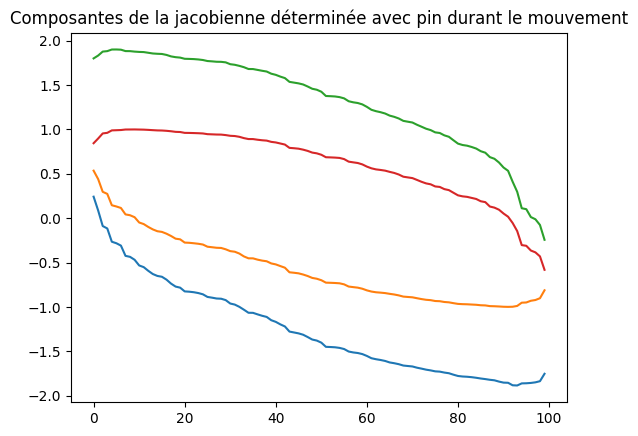

In [17]:
nb_, nb_DL, _ = Jee_list.shape
plt.plot(Jee_casadi_list[0,0,:])
plt.plot(Jee_casadi_list[0,1,:])
plt.plot(Jee_casadi_list[1,0,:])
plt.plot(Jee_casadi_list[1,1,:])
# plt.plot(Jee_casadi_list[2,0,:])
# plt.plot(Jee_casadi_list[2,1,:])
plt.title("Composantes de la jacobienne déterminée avec pin durant le mouvement")

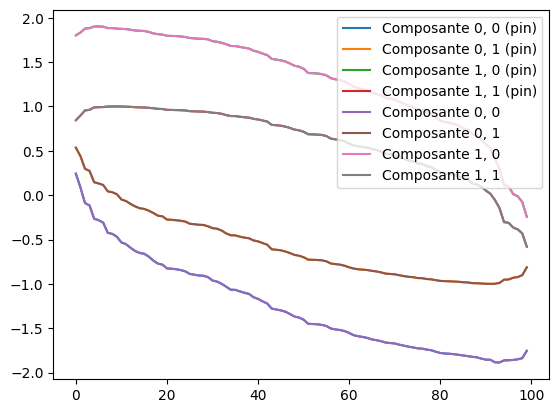

In [20]:
nb_, nb_DL, _ = Jee_list.shape
plt.plot(Jee_casadi_list[0,0,:], label=f"Composante 0, 0 (pin)")
plt.plot(Jee_casadi_list[0,1,:], label=f"Composante 0, 1 (pin)")
plt.plot(Jee_casadi_list[1,0,:], label=f"Composante 1, 0 (pin)")
plt.plot(Jee_casadi_list[1,1,:], label=f"Composante 1, 1 (pin)")
# for ind_vit in range(nb_directions):
for ind_vit in range(2):
    for ind_DL in range(nb_DL):
        plt.plot(Jee_list[ind_vit,ind_DL,:], label=f"Composante {ind_vit}, {ind_DL}")
plt.legend()
plt.show()

In [92]:
J_func(0,math.pi/2)

DM(
[[-1, -1], 
 [1, 6.12323e-17], 
 [00, 00]])

## **Réimplémentation des méthodes de génération de trajectoire (Kalakrishnan 2011)**

### **Première génération de trajectoires : from scratch (seulement le début, voir plus bas pour la réutilisation des travaux de Vincent Bonnet et Maxime Sabbah)**

In [44]:
q_opt = np.vstack((q1, q2))
dq_opt = np.vstack((dq1, dq2))

P_x_opt = L_1*np.cos(q_opt[0,:]) + L_2*np.cos(q_opt[0,:] + q_opt[1,:])
P_y_opt = L_1*np.sin(q_opt[0,:]) + L_2*np.sin(q_opt[0,:] + q_opt[1,:])

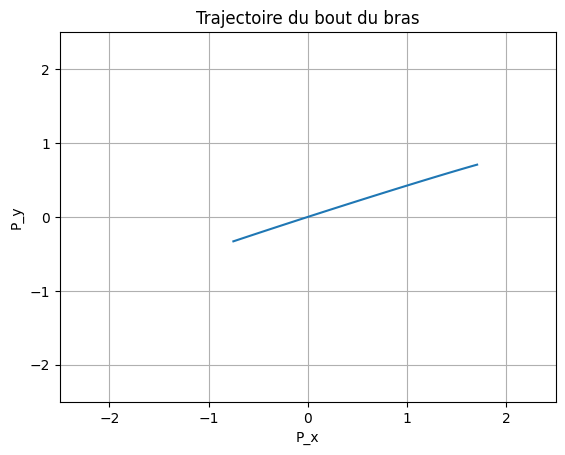

In [ ]:
plt.plot(P_x_opt, P_y_opt)
plt.xlabel('P_x')
plt.ylabel('P_y')
plt.title('Trajectoire du bout du bras')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.grid()
plt.show()

In [30]:
import numpy as np

def generate_noisy_trajectories(theta, K=20, joint_limits=None):
    """
    Génère des trajectoires bruitées à partir d'une trajectoire optimale.
    
    theta: np.array de taille (N, dof), trajectoire optimale (q1, q2,...)
    K: nombre d'échantillons bruités
    joint_limits: [(min, max), ...] pour chaque articulation
    """
    N, dof = theta.shape

    # Matrice de différences finies pour accélération
    A = np.zeros((N, N))
    A[0,0] = -2.0*N**2      # AJOUT
    A[0,1] = 1.0*N**2       # AJOUT
    A[N-1, N-2] = 1.0*N**2  # AJOUT
    A[N-1, N-1] = -2.0*N**2 # AJOUT
    for i in range(1, N-1):
        A[i, i-1:i+2] = [1.0*N**2, -2.0*N**2, 1.0*N**2]
    R = A.T @ A
    print(A)
    Rinv = np.linalg.pinv(R)  # covariance approx.

    noisy_trajectories = []
    eps_tab = np.zeros((N, dof, K))
    for k in range(K):
        noisy = theta.copy()
        for d in range(dof):
            eps = np.random.multivariate_normal(mean=np.zeros(N), cov=Rinv)
            eps_tab[:, d, k] = eps
            noisy[:, d] += eps
            # Respect des limites articulaires
            if joint_limits:
                min_j, max_j = joint_limits[d]
                noisy[:, d] = np.clip(noisy[:, d], min_j, max_j)
        noisy_trajectories.append(noisy)
    
    return noisy_trajectories, eps_tab

In [31]:
noisy_trajectories_around_optimal, eps_tab = generate_noisy_trajectories(q_opt.T, K=5)

[[-20000.  10000.      0. ...      0.      0.      0.]
 [ 10000. -20000.  10000. ...      0.      0.      0.]
 [     0.  10000. -20000. ...      0.      0.      0.]
 ...
 [     0.      0.      0. ... -20000.  10000.      0.]
 [     0.      0.      0. ...  10000. -20000.  10000.]
 [     0.      0.      0. ...      0.  10000. -20000.]]


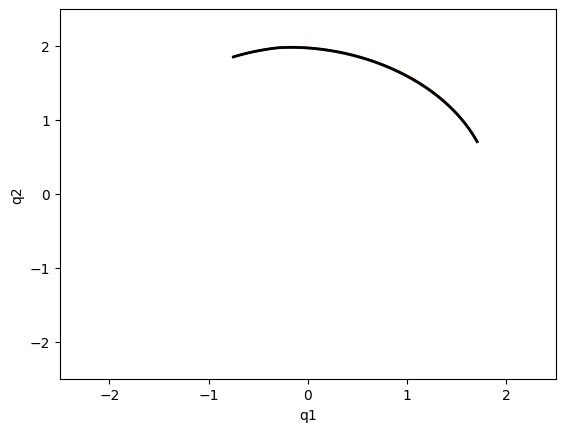

In [11]:
P_x_noisy = []
P_y_noisy = []

for noisy_traj in noisy_trajectories_around_optimal:
    current_noisy_Px = L_1*np.cos(noisy_traj[:,0]) + L_2*np.cos(noisy_traj[:,0] + noisy_traj[:,1])
    current_noisy_Py = L_1*np.sin(noisy_traj[:,0]) + L_2*np.sin(noisy_traj[:,0] + noisy_traj[:,1])
    P_x_noisy.append(current_noisy_Px)
    P_y_noisy.append(current_noisy_Py)
    plt.plot(current_noisy_Px, current_noisy_Py, alpha=0.5)
plt.plot(P_x_opt, P_y_opt, 'k-', linewidth=2, label='Optimal Traj')
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.xlabel('q1')
plt.ylabel('q2')
plt.show()

In [12]:
centred_to_opt = np.array([P_x_noisy, P_y_noisy]).swapaxes(0,1) - np.array([[P_x_opt, P_y_opt]])
dist_to_opt = np.linalg.norm(centred_to_opt, axis=1)

In [13]:
dist_to_opt.shape

(5, 100)

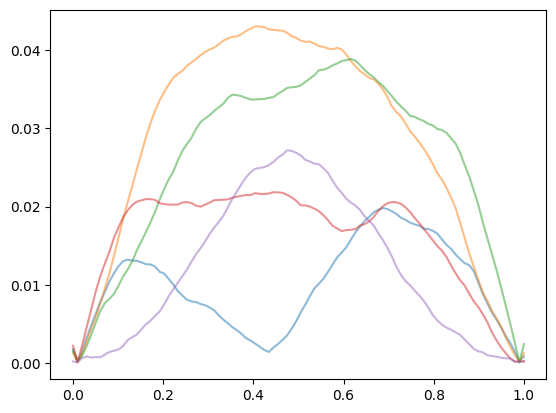

In [14]:
for one_dist_to_opt in dist_to_opt:
    plt.plot(np.linspace(0,1,100), one_dist_to_opt, alpha=0.5)

In [15]:
eps_tab_reshape = eps_tab.reshape(10, -1)

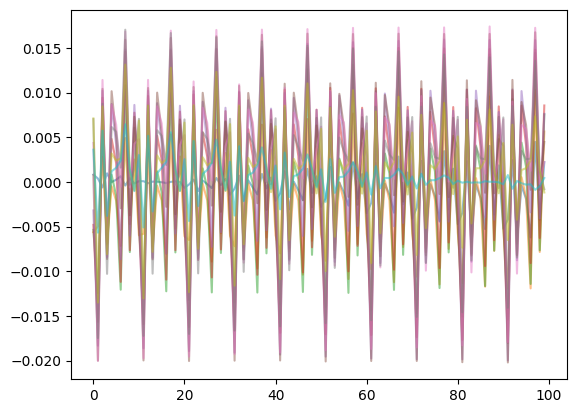

In [16]:
for eps in eps_tab_reshape:
    plt.plot(eps, alpha=0.5)

In [18]:
A = np.zeros((N, N))
A[0,1] = 1.0
A[N-1, N-2] = 1.0
for i in range(1, N-1):
    A[i, i-1:i+2] = [1.0, -2.0, 1.0]
R = A.T @ A
Rinv = np.linalg.pinv(R)  # covariance approx.
zero_mean = np.zeros(N)

In [ ]:
# Implémentation de la génération des bruits, selon Kalakrishnan 2011
# NOTE : je pense qu'il y a une coquille dans le papier et que la matrice A est mal définie

"""
A = np.zeros((N, N))
A[1,0] = -2.0
A[2,0] = 1.0
A[2,1] = -2.0
A[N-3, N-2] = -2.0
A[N-3, N-1] = 1.0
A[N-2, N-1] = -2.0
for i in range(N):
    # A[i, i-1:i+2] = [1.0*N**2, -2.0*N**2, 1.0*N**2]
    A[i, i] = 1.0
A = A * (1/N**2)
R = A.T @ A
Rinv = np.linalg.pinv(R)  # covariance approx.
zero_mean = np.zeros(N)

vec = np.random.multivariate_normal(zero_mean, Rinv)"""

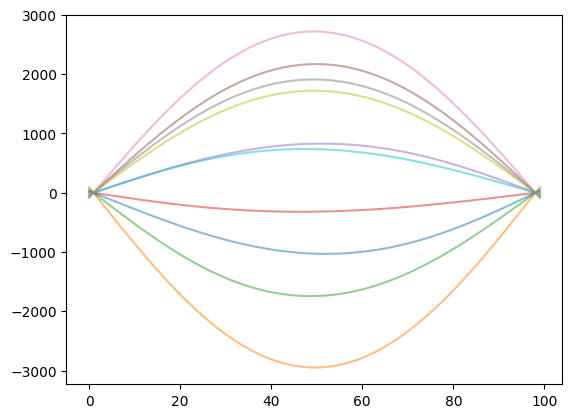

In [19]:
for eps in eps_tab_reshape:
    plt.plot(Rinv@eps, alpha=0.5)

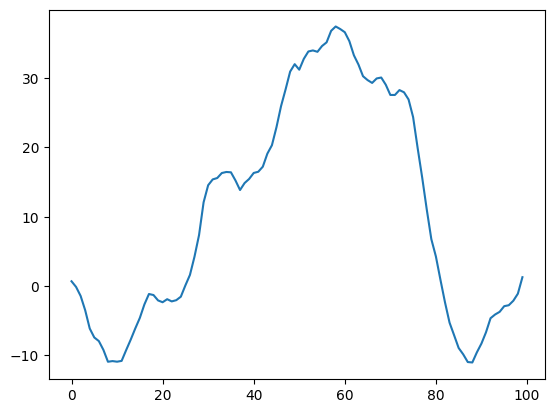

In [20]:
vec = np.random.multivariate_normal(zero_mean, Rinv)
plt.plot(vec)

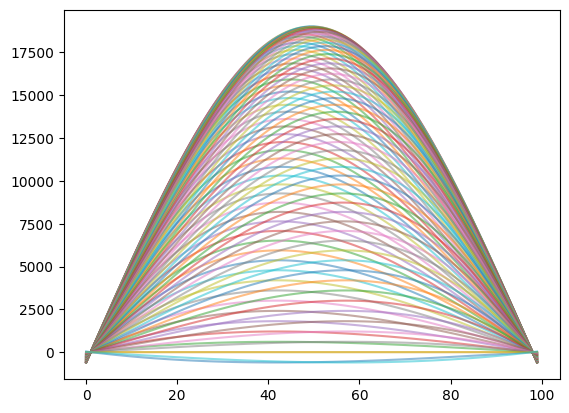

In [21]:
for i in range(N):
    plt.plot(Rinv[i], alpha=0.5)

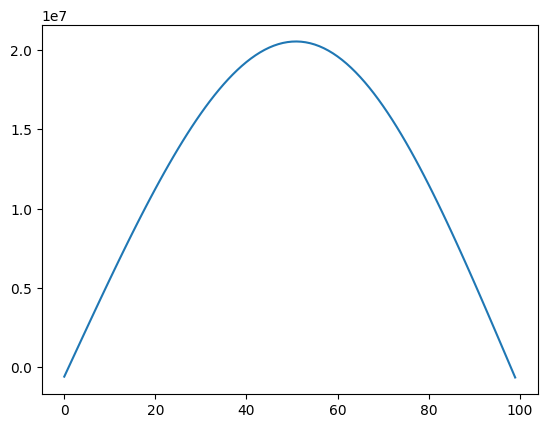

In [22]:
plt.plot(Rinv@vec)

## **Résolution de DOC avec cpin**

In [54]:
exampleRobotDataPath = '/home/n7student/Documents/Boulot/CNRS@CREATE/Codes/OC & IRL/Starting/3 - URDF et pinocchio/assets/'
urdf = exampleRobotDataPath + 'mon_robot.urdf'
robot = RobotWrapper.BuildFromURDF( urdf, [ exampleRobotDataPath, ] )
# robot.setVisualizer(GepettoVisualizer()) # AJOUT
robot.initViewer(loadModel=True)
NQ = robot.model.nq
NV = robot.model.nv

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [7]:
cmodel = cmodel = cpin.Model(robot.model)
cdata = cdata = cmodel.createData()

q = ca.SX.sym("q",NQ,1)
dq = ca.SX.sym("dq",NQ,1)
ddq = ca.SX.sym("ddq",NQ,1)     # NORMALEMENT PAS BESOIN

In [9]:
# Implémentation des fonctions nécessaires au calcul des coûts avec cpin

frame_id = cmodel.getFrameId("ee_link")


def vtip_fun(q):
    # cpin.forwardKinematics(cmodel, cdata, q)
    v_frame = cpin.getFrameVelocity(cmodel, cdata, frame_id, pin.ReferenceFrame.LOCAL)
    # NOTE : vérifier que ce sont bien les deux bonnes composantes de la vitesse
    return v_frame.linear[[0, 2]]

vtip = ca.Function('vtip', [q], [vtip_fun(q)])

vtip_val = vtip(q) 
vx_sq = ca.dot(vtip_val[0], vtip_val[0])
vy_sq = ca.dot(vtip_val[1], vtip_val[1])

vx_sq_fun = ca.Function("vx_sq_fun", [q], [vx_sq])
vy_sq_fun = ca.Function("vy_sq_fun", [q], [vy_sq])

# oMtool = robot.data.oMf[IDX_EE]
# oRtool = oMtool.rotation
# Jee = oRtool[:2,:2] @ (pin.computeFrameJacobian(robot.model,robot.data,np.array([q1_test[i],q2_test[i]]),IDX_EE)[:2,:2])

# jac_fun = ca.Function("jac_fun", [q], [cpin.computeJointJacobians(cmodel,cdata,q)])
# jac_fun = ca.Function("jac_fun", [q], [(robot.data.oMf[IDX_EE].rotation)[:2,:2] @ (cpin.computeFrameJacobian(cmodel, cdata, q, IDX_EE)[:2,:2])])
jac_fun = ca.Function("jac_fun", [q], [cpin.computeFrameJacobian(cmodel, cdata, q, IDX_EE, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)])

manipulability_fun = ca.Function("manipulability_fun", [q], [jac_fun(q) @ jac_fun(q).T])

cost_manipulability_fun = ca.Function("cost_manipulability_fun", [q], [-ca.log(ca.det(manipulability_fun(q)) + 1e-6)])

In [8]:
# Implémentation des fonctions nécessaires au calcul des coûts avec cpin

frame_id = robot.model.getFrameId("ee_link")
# model = robot.model
# data = robot.data


def vtip_fun(q):
    # cpin.forwardKinematics(cmodel, cdata, q)
    v_frame = pin.getFrameVelocity(robot.model, robot.data, frame_id, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
    # NOTE : vérifier que ce sont bien les deux bonnes composantes de la vitesse
    return v_frame.linear[[0, 2]]

vtip = ca.Function('vtip', [q], [vtip_fun(q)])

vtip_val = vtip(q) 
vx_sq = ca.dot(vtip_val[0], vtip_val[0])
vy_sq = ca.dot(vtip_val[1], vtip_val[1])

vx_sq_fun = ca.Function("vx_sq_fun", [q], [vx_sq])
vy_sq_fun = ca.Function("vy_sq_fun", [q], [vy_sq])

# oMtool = robot.data.oMf[IDX_EE]
# oRtool = oMtool.rotation
# Jee = oRtool[:2,:2] @ (pin.computeFrameJacobian(robot.model,robot.data,np.array([q1_test[i],q2_test[i]]),IDX_EE)[:2,:2])

# jac_fun = ca.Function("jac_fun", [q], [cpin.computeFrameJacobian(cmodel,cdata,q, IDX_EE, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)])
# jac_fun = ca.Function("jac_fun", [q], [(robot.data.oMf[IDX_EE].rotation)[:2,:2] @ (cpin.computeFrameJacobian(cmodel, cdata, q, IDX_EE)[:2,:2])])
jac_fun = ca.Function("jac_fun", [q], [pin.computeFrameJacobian(robot.model, robot.data, q, IDX_EE, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)])

manipulability_fun = ca.Function("manipulability_fun", [q], [jac_fun(q) @ jac_fun(q).T])

cost_manipulability_fun = ca.Function("cost_manipulability_fun", [q], [-ca.log(ca.det(manipulability_fun(q)) + 1e-6)])

ArgumentError: Python argument types in
    pinocchio.pinocchio_pywrap_default.computeFrameJacobian(Model, Data, SX, int, ReferenceFrame)
did not match C++ signature:
    computeFrameJacobian(pinocchio::ModelTpl<double, 0, pinocchio::JointCollectionDefaultTpl> model, pinocchio::DataTpl<double, 0, pinocchio::JointCollectionDefaultTpl> {lvalue} data, Eigen::Matrix<double, -1, 1, 0, -1, 1> q, unsigned long frame_id)
    computeFrameJacobian(pinocchio::ModelTpl<double, 0, pinocchio::JointCollectionDefaultTpl> model, pinocchio::DataTpl<double, 0, pinocchio::JointCollectionDefaultTpl> {lvalue} data, Eigen::Matrix<double, -1, 1, 0, -1, 1> q, unsigned long frame_id, pinocchio::ReferenceFrame reference_frame)

In [60]:
jac_fun(ca.DM([0,ca.pi/2]))

DM(
[[1, 0], 
 [1, 1]])

In [21]:
cpin.framesForwardKinematics(cmodel, cdata, ca.DM([0.0,0.0]))

ArgumentError: Python argument types in
    pinocchio.pinocchio_pywrap_casadi.framesForwardKinematics(Model, Data, DM)
did not match C++ signature:
    framesForwardKinematics(pinocchio::ModelTpl<casadi::Matrix<casadi::SXElem>, 0, pinocchio::JointCollectionDefaultTpl> model, pinocchio::DataTpl<casadi::Matrix<casadi::SXElem>, 0, pinocchio::JointCollectionDefaultTpl> {lvalue} data, Eigen::MatrixBase<Eigen::Matrix<casadi::Matrix<casadi::SXElem>, -1, 1, 0, -1, 1> > q)

In [17]:
opti = ca.Opti()

# cadre du problème
# temporel
t_0 = 0
t_f = 1
N = 100  # nombre de points de discrétisation
dt = (t_f - t_0) / N

# longueurs
L_1 = 1
L_2 = 1
N_angles = 2

# variables à optimiser
q = opti.variable(N_angles, N)
q_fic = opti.variable(1, N)
dq = opti.variable(N_angles, N)

# déclaration de la matrice de poids
# NOTE : j'avais mis des np.ones au début, mais cela ne marchait pas, il faut essayer de rester avec des objets casadi
w_1 = ca.DM.ones((N_angles, N))
w_2 = ca.DM.zeros(N)
w_3 = ca.DM.zeros(N)
w_4 = ca.DM.ones(N)


# \Phi_1 : coût sur les vitesses angulaires
Phi_1 = dq**2
J_1 = w_1[0,:] @ Phi_1[0,:].T + w_1[1,:] @ Phi_1[1,:].T

# variables symboliques indépendantes pour un pas de temps
q_sym = ca.MX.sym("q", 2)


J_2 = 0
J_3 = 0
J_4 = 0
save_cost_manipulability = []
for t in range(N):
    q_t = ca.vertcat(q[0, t], q[1, t])
    # q_t = ca.vertcat(q[0, t], q[1, t], q_fic[0, t])
    # cpin.framesForwardKinematics(cmodel, cdata, q_t)
    J_2 += w_2[t] * vx_sq_fun(q_t)
    J_3 += w_3[t] * vy_sq_fun(q_t)
    J_4 += w_4[t] * cost_manipulability_fun(q_t)

# fonction que l'on cherche à minimiser
opti.minimize(J_1 + J_2 + J_3 + J_4)

# contraintes d’intégration
opti.subject_to(q_fic[0, N-1] == 0)
for t in range(N-1):
    opti.subject_to(q[:, t+1] == q[:, t] + dt * dq[:, t])
    opti.subject_to(q_fic[0, t] == 0)
opti.subject_to(q[:, 0] == [0, ca.pi/4])
opti.subject_to(L_1*ca.cos(q[0, -1]) + L_2*ca.cos(q[0, -1] + q[1, -1]) == -0.75)

# conditions supplémentaires sur les angles, non demandé dans l'énoncé
# opti.subject_to(opti.bounded(-pi/2, q, pi/2))

opti.solver("ipopt")
sol = opti.solve()

q1_cpin = sol.value(q[0,:])
q2_cpin = sol.value(q[1,:])

dq1_cpin = sol.value(dq[0,:])
dq2_cpin = sol.value(dq[1,:])

print("q1 =", q1_cpin)
print("q2 =", q2_cpin)
print("dq1 =", dq1_cpin)
print("dq2 =", dq2_cpin)

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:      698
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      203

Total number of variables............................:      500
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      301
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.3815511e+03 2.75e+00 0.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

In [17]:
Jee_list = np.zeros((2,2,N))

for i in range(N):
    cpin.framesForwardKinematics(cmodel, cdata, np.array([q1_cpin[i],q2_cpin[i]]))
    # print("Tool placement:",robot.data.oMf[IDX_EE])
    Jee = cpin.computeFrameJacobian(robot.model,robot.data,np.array([q1[i],q2[i]]),IDX_EE)
    print(Jee[0:2])
    Jee_list[:,:,i] = Jee[0:2]
    time.sleep(0.1)

ArgumentError: Python argument types in
    pinocchio.pinocchio_pywrap_casadi.framesForwardKinematics(Model, Data, numpy.ndarray)
did not match C++ signature:
    framesForwardKinematics(pinocchio::ModelTpl<casadi::Matrix<casadi::SXElem>, 0, pinocchio::JointCollectionDefaultTpl> model, pinocchio::DataTpl<casadi::Matrix<casadi::SXElem>, 0, pinocchio::JointCollectionDefaultTpl> {lvalue} data, Eigen::MatrixBase<Eigen::Matrix<casadi::Matrix<casadi::SXElem>, -1, 1, 0, -1, 1> > q)

In [20]:
robot.display(np.array([q1_cpin[0],q2_cpin[0]]))

In [21]:
robot.display(np.array([q1_cpin[-1],q2_cpin[-1]]))

In [18]:
robot.display(np.array([q1_cpin[0], q2_cpin[0]]))

time.sleep(2)
for i in range(N):
    robot.display(np.array([q1_cpin[i],q2_cpin[i]]))
    time.sleep(0.1)

In [19]:
for i in range(N):
    print(cost_manipulability_fun(ca.vertcat(q1_cpin[i], q2_cpin[i])))

13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155
13.8155


#### **Comparaison des angles obtenus**

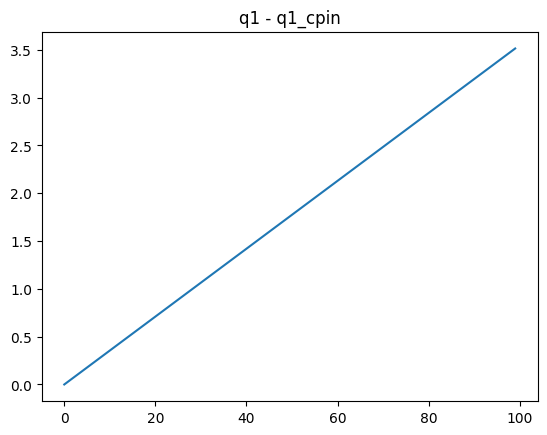

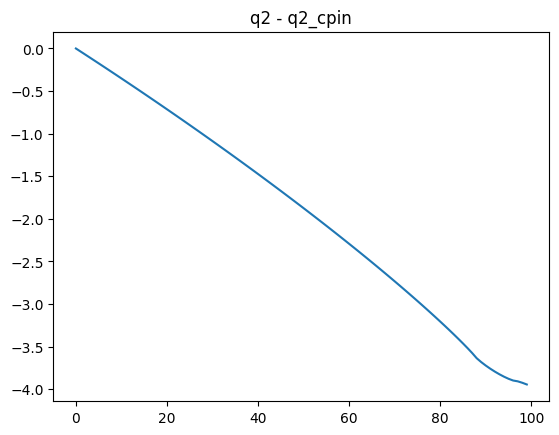

In [12]:
plt.plot(q1 - q1_cpin)
plt.title("q1 - q1_cpin")
plt.show()

plt.plot(q2 - q2_cpin)
plt.title("q2 - q2_cpin")
plt.show()

### **Récupération et analyse package IRL**

In [ ]:
from tools import irl_utils

#### **Analyse de la matrice $R$ définie dans le package**

##### **Fonction `finite_difference_matrix`**

In [43]:
A = irl_utils.finite_difference_matrix(10,1)
A

array([[-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.]])

In [44]:
A.shape

(10, 10)

Selon moi, c'est cette matrice qu'il faut garder. Mais dans l'implémentation de l'IRL, Vincent et Maxime ont ajouté ce qu'il suit :

*Note : après discussion avec Maxime, il est normal d'avoir une matrice non-carrée.*

In [53]:
A = irl_utils.finite_difference_matrix(10,1)
A0=np.zeros(10)
A0[0]=1
A=np.vstack((A0,A))
A0[0]=0
A0[-1]=1
A=np.vstack((A,A0))

In [54]:
A

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1., -2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]])

In [39]:
A.shape

(12, 10)

#### **Début d'application dans notre cas**

In [ ]:
h = 1/N
A = irl_utils.finite_difference_matrix(N,h)
A0=np.zeros(N)
A0[0]=1
A=np.vstack((A0,A))
A0[0]=0
A0[-1]=1
A=np.vstack((A,A0))

Rinv = np.linalg.inv(A.T @ A)

# L = np.linalg.cholesky(Rinv)

Continuation par ma démarche

In [ ]:
q1_bruite = q1 + np.random.multivariate_normal(np.zeros(N), Rinv)
q2_bruite = q2 + np.random.multivariate_normal(np.zeros(N), Rinv)

In [69]:
for i in range(N):
    robot.display(np.array([q1_bruite[i],q2_bruite[i]]))
    time.sleep(0.1)

Visuellement, le bruit semble trop faible, ce qui peut se visualiser par les graphes ci-dessous

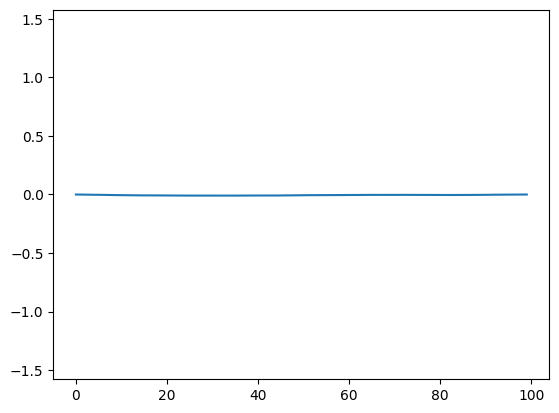

In [77]:
plt.plot(q1 - q1_bruite)
plt.ylim(-max(abs(q1)), max(abs(q1)))
plt.show()

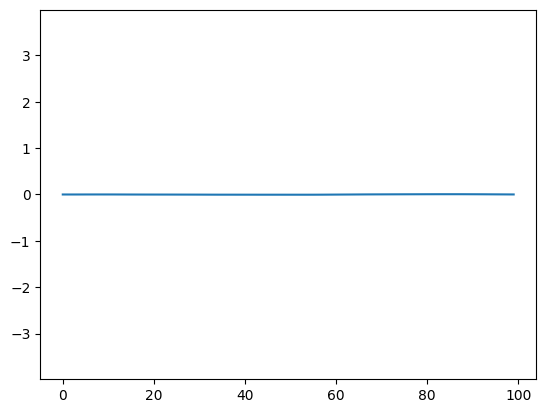

In [78]:
plt.plot(q2 - q2_bruite)
plt.ylim(-max(abs(q2)), max(abs(q2)))
plt.show()

Je pense que cela vient du coefficient h, qui ne doit peut-être pas être incorporé tel quel dans la covariance. Si l'on donne du sens à notre équation, on a :
$$
\ddot{\theta} = A \theta
$$

d'où, dans le cas où $A$ est inversible :

$$
\theta = A^{-1} \ddot{\theta}
$$

Ainsi, dans l'idée, on doit ajouter un bruit de $\theta$ basé sur l'ordre de grandeur de $A^{-1}$.

NOTE : il faut donc calculer avec les coefficients précis propres au schéma de différence finies, mais ça sera quelque chose en $1/h^2$ et non pas en $1/h$.

In [48]:
h = 1/N
A = irl_utils.finite_difference_matrix(N,h)
A0=np.zeros(N)
A0[0]=1
A=np.vstack((A0,A))
A0[0]=0
A0[-1]=1
A=np.vstack((A,A0))

Rinv = np.linalg.inv(A.T @ A)

q1_bruite = q1 + np.random.multivariate_normal(np.zeros(N), 10*Rinv)
q2_bruite = q2 + np.random.multivariate_normal(np.zeros(N), 10*Rinv)

for i in range(N):
    robot.display(np.array([q1_bruite[i],q2_bruite[i]]))
    time.sleep(0.1)

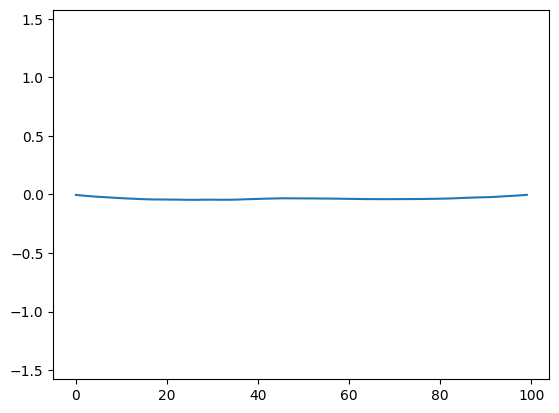

In [49]:
plt.plot(q1 - q1_bruite)
plt.ylim(-max(abs(q1)), max(abs(q1)))
plt.show()

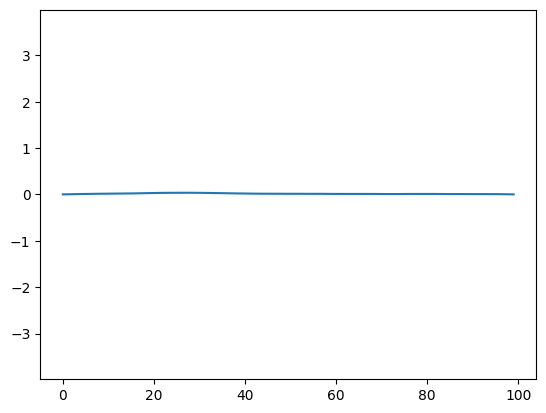

In [50]:
plt.plot(q2 - q2_bruite)
plt.ylim(-max(abs(q2)), max(abs(q2)))
plt.show()

In [ ]:
q_nopt=np.empty( (param["nb_samples"],param["nb_joints"],param["nb_nopt"]) )